In [1]:
# Install dependencies
import sys
!{sys.executable} -m pip install pandas matplotlib openpyxl scipy ipywidgets


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Read Excel file, organise data, then save as csv for faster loading next time
from os.path import exists
import pandas as pd
from math import floor

filestem = 'data/Compil_All'
fs = 100  # sampling rate

if exists(f"{filestem}.csv"):
    print("Loading CSV file...")
    df = pd.read_csv(f"{filestem}.csv")  # much much much quicker (once available)
    df = df.set_index('Time')
    no_participants = max(df['Subject'])
    print("Loaded.")
else:
    # Read Excel file (very slow as assumes rectangular data)
    print("Loading Excel file...")
    df = pd.read_excel(
        f"{filestem}.xlsx",
        header=1,  # Header row number
    )
    print("Loaded.")
    # Throw away blank columns
    df = df.drop(
        labels=(col for col in df.columns if 'Unnamed' in col),
        axis='columns',
    )
    # Give first participants' columns an id number (for consistency)
    cols = list(df.columns)
    metrics = cols[:6]
    cols[:6] = [f"{col}.0" for col in list(metrics)]
    df.columns = cols
    # Assign multi-column indexing to separate metrics from participant IDs
    no_participants = int(len(df.columns)/len(metrics))
    metrics_cols = no_participants * metrics
    participants_cols = [ floor((n+1)/len(metrics)) for n in range(no_participants*len(metrics)) ]
    multicol = [ metrics_cols, participants_cols ]
    df.columns = multicol
    # Make row index a time-series, given the sampling rate
    df = df.set_index(pd.Series(df.index)/fs)
    # Pivot table
    df = df.stack()
    # Remove blank rows
    df = df.dropna()
    # Convert indices to columns to preserve labels during CSV save/load
    df = df.reset_index()
    df.columns = ['Time', 'Subject', *metrics]
    # Save csv
    print("Saving CSV...")
    df.to_csv(f'{filestem}.csv', index=False)
    print("Done.")

# Preview dataframe (also let's us know its loaded)
print(df)

Loading CSV file...
Loaded.
        Subject   acc X   acc Y   acc Z     ang X    ang Y     ang Z
Time                                                                
0.00          1  0.8750  0.0537 -0.5269  175.7812 -59.2603  120.1080
0.00          2  1.1025  0.1973 -0.3481  141.5039 -72.8943  -27.4274
0.00          3  0.9282  0.1470 -0.4292  151.7157 -63.4845  -43.2312
0.00          4  0.9810  0.0610 -0.2710  164.4818 -74.3060  -46.6589
0.00          5  1.0078  0.1318 -0.1519  139.0100 -77.7448  -60.1007
...         ...     ...     ...     ...       ...      ...       ...
591.70        6  0.9639 -0.0952 -0.1182 -171.2604 -82.5293   27.1033
591.71        6  0.9639 -0.0952 -0.1182 -169.9750 -82.5238   28.2239
591.72        6  0.9199 -0.0938 -0.1240 -168.7994 -82.4854   29.4269
591.73        6  0.9199 -0.0938 -0.1240 -167.6349 -82.4469   30.6958
591.74        6  0.9111 -0.0933 -0.1299 -166.7505 -82.3535   32.0361

[528962 rows x 7 columns]


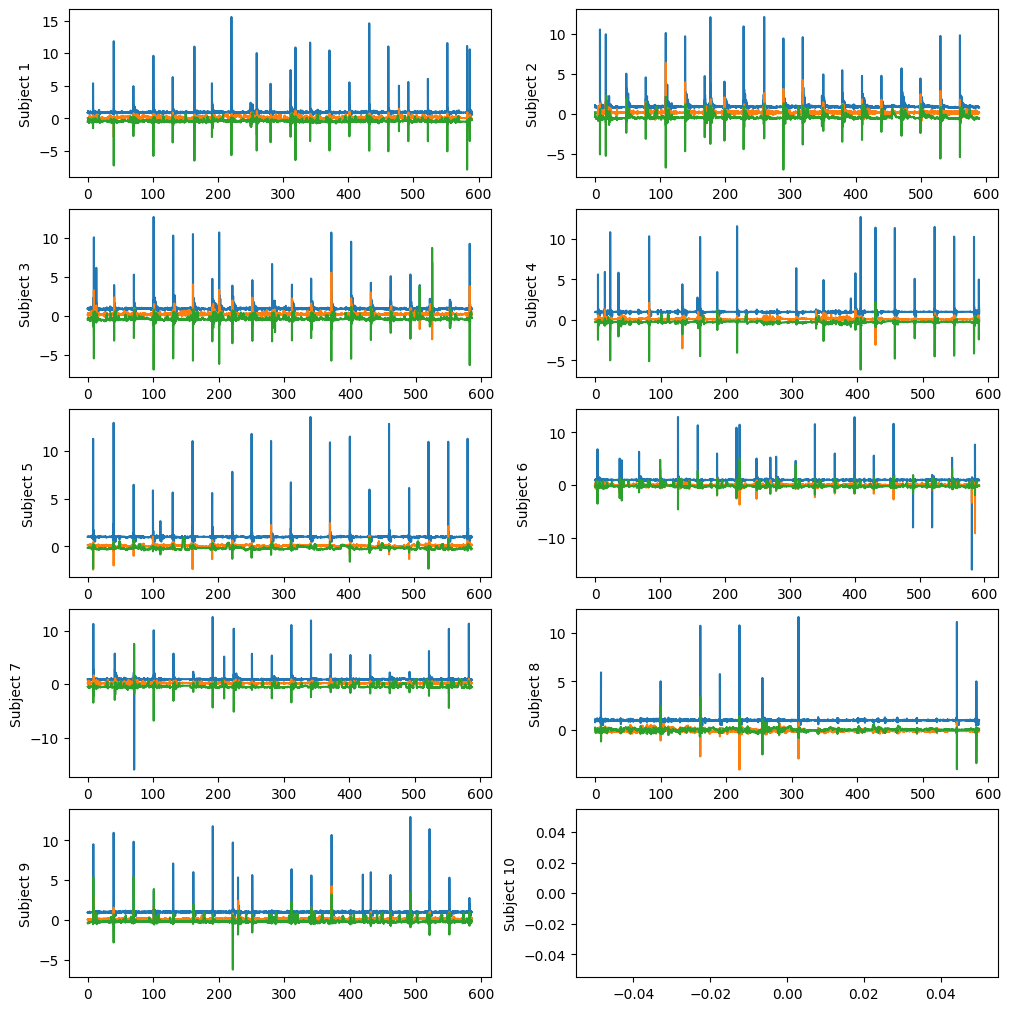

In [3]:
# Plot acceleration data (quick check - all subjects)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,10), layout='constrained')
for subject, ax in enumerate(axs.flat):
    for metric in ['acc X', 'acc Y', 'acc Z']:
        ax.plot(df[metric][df['Subject']==subject+1])
        ax.set_ylabel(f'Subject {subject+1}')

In [5]:
# Plot data (closer look - single subject)
from ipywidgets import interact

def plotSubject(Subject=1):
    # Plot accelerometer traces
    plt.figure(figsize=(10,6))
    plt.title(f'Accelerometer series (Subject {Subject})')
    plt.xlabel('Time (secs)')
    plt.ylabel('g')
    plot_metrics = ['acc X', 'acc Y', 'acc Z']
    for metric in plot_metrics:
        plt.plot(df[metric][df['Subject']==Subject])
    plt.legend(plot_metrics)
    plt.show()

interact(plotSubject, Subject=(1,no_participants), value=1)

interactive(children=(IntSlider(value=1, description='Subject', max=9, min=1), Output()), _dom_classes=('widge…

<function __main__.plotSubject(Subject=1)>

In [6]:
# Plot power spectrum of channels
import statistics
import numpy as np
from scipy import signal

# Plot data (closer look - single subject)
from ipywidgets import interact

def plotSubject(Subject=1):
    plt.figure()
    plt.title(f'Power spectrum (Subject {Subject})')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Linear spectrum [RMS]')
    plot_metrics = ['acc X', 'acc Y', 'acc Z']
    for metric in plot_metrics:
        y = df[metric][df['Subject']==Subject]
        y = y - statistics.mean(y)  # demean
        f, Pxx_spec = signal.welch(y, fs, 'flattop', 1024, scaling='spectrum')
        plt.semilogy(f, np.sqrt(Pxx_spec))
    plt.legend(plot_metrics)
    plt.show()

interact(plotSubject, Subject=(1,no_participants), value=1)

interactive(children=(IntSlider(value=1, description='Subject', max=9, min=1), Output()), _dom_classes=('widge…

<function __main__.plotSubject(Subject=1)>

In [7]:
# Plot RMS (single subject)
from scipy.ndimage import uniform_filter1d

smoothing_secs = 0.100  # smoothing (secs)

# rms (after per-subject per-channel demean)
df['acc rms'] = 0.0
df['acc rms smooth'] = 0.0
smoothing = 2*floor(smoothing_secs*fs/2)+1  # ensure symmetrical smoothing window
for Subject in range(1,no_participants+1):
    df.loc[df['Subject']==Subject, ['acc rms']] = (
        (df['acc X'][df['Subject']==Subject]-statistics.mean(df['acc X'][df['Subject']==Subject]))**2 +
        (df['acc Y'][df['Subject']==Subject]-statistics.mean(df['acc Y'][df['Subject']==Subject]))**2 +
        (df['acc Z'][df['Subject']==Subject]-statistics.mean(df['acc Z'][df['Subject']==Subject]))**2
    )**(1/2)
    df.loc[df['Subject']==Subject, ['acc rms smooth']] = \
        uniform_filter1d(df['acc rms'][df['Subject']==Subject], size=smoothing)
    df.loc[df['Subject']==Subject, ['acc rms smooth diff']] = df['acc rms smooth'][df['Subject']==Subject].diff()

def plotSubject(Subject=1):
    # Draw two plots the same, then enlarge the second one for detail
    fig, axs = plt.subplots(2, 1, figsize=(10,6), layout='constrained')
    for subject, ax in enumerate(axs.flat):
        ax.set_xlabel('Time (secs)')
        ax.set_ylabel('g [RMS]')
        ax.plot(df['acc rms'][df['Subject']==Subject])
        ax.plot(df['acc rms smooth'][df['Subject']==Subject])

    axs[0].set_title(f'Root-Mean-Square [RMS] for Accelerometer (Subject {Subject})')
    axs[1].set_title('Enlargement (100-200 secs)')
    axs[1].set_xlim(100, 200)
    axs[1].legend(['RMS', f'Smooth ({smoothing_secs} secs)'])
    plt.show()

interact(plotSubject, Subject=(1,no_participants), value=1)

interactive(children=(IntSlider(value=1, description='Subject', max=9, min=1), Output()), _dom_classes=('widge…

<function __main__.plotSubject(Subject=1)>

In [8]:
# Plot Smooth RMS and diff of Smooth RMS signal
# (consider using in peak finding)

def plotSubject(Subject=1):
    plt.figure(figsize=(10, 6))
    plt.title(f'Accelerometer series (Subject {Subject})')
    plt.xlabel('Time (secs)')
    plt.ylabel('g [RMS]')
    plt.plot(df['acc rms smooth'][df['Subject'] == Subject])
    plt.plot(df['acc rms smooth'][df['Subject'] == Subject].diff())
    plt.xlim(100, 200)
    plt.legend(['RMS', 'Diff RMS'])
    plt.show()

interact(plotSubject, Subject=(1,no_participants), value=1)

interactive(children=(IntSlider(value=1, description='Subject', max=9, min=1), Output()), _dom_classes=('widge…

<function __main__.plotSubject(Subject=1)>

In [9]:
# Find and plot peaks - peak find runs on processed data
from scipy.signal import find_peaks

threshold = 0.1
min_separation_secs = 5.0  # minimum separation time (secs)

# Save peak locations and raw accelerometer RMS value to new dataframe
peaks = pd.DataFrame()
for Subject in range(1, no_participants+1):
    # Isolate data for peak finding
    y = df.loc[df['Subject'] == Subject][['acc rms']]
    ys = df.loc[df['Subject'] == Subject][['acc rms smooth']]
    ysd = ys.diff()
    peak_locs = find_peaks(
        ysd['acc rms smooth'],
        threshold=threshold,
        distance=int(min_separation_secs*fs),
    )[0]
    peak_rms = np.zeros(len(peak_locs))
    # Fine adjustment - iterate through peaks and find max in *raw* RMS signal
    for ix, peak in enumerate(peak_locs):
        y_window = y.loc[(y.index>(y.index[peak]-smoothing_secs)) &
                         (y.index<(y.index[peak]+smoothing_secs))][['acc rms']]
        # Update peak location based on raw RMS signal
        peak_rms[ix] = max(y_window['acc rms'])
    # Save peak locations and RMS values to new dataframe
    peaks = pd.concat( [peaks, pd.DataFrame(
        data = {
            'Subject': [Subject for n in range(0,len(peak_locs))],
            'Sample': peak_locs,
            'Time': y.index[peak_locs],
            'rms': peak_rms,
            'rms smooth diff': ysd.iloc[peak_locs]['acc rms smooth'],
        }
    )])

# Plot
def plotSubject(Subject=1):
    fig, axs = plt.subplots(2, 1, figsize=(10,6), layout='constrained')
    # plot peak find locations on raw data
    ax = axs[0]
    ax.set_title(f'Peak find [RMS] (Subject {Subject})')
    ax.set_xlabel('Time (secs)')
    ax.set_ylabel('g [RMS]')
    ax.plot(df['acc rms'][df['Subject'] == Subject])
    ax.plot(
        peaks['Time'][peaks['Subject'] == Subject],
        peaks['rms'][peaks['Subject'] == Subject],
        'o'
    )
    # plot peak find results on processed data
    ax = axs[1]
    ax.set_title(f'Peak find on processed data (Diff of Smoothed [{smoothing_secs} secs] data)')
    ax.set_xlabel('Time (secs)')
    ax.set_ylabel('Diff of g [RMS]')
    ax.plot(df['acc rms smooth diff'][df['Subject'] == Subject])
    ax.plot(
        peaks['Time'][peaks['Subject'] == Subject],
        peaks['rms smooth diff'][peaks['Subject'] == Subject],
        'o'
    )
    plt.show()

interact(plotSubject, Subject=(1,no_participants), value=1)

interactive(children=(IntSlider(value=1, description='Subject', max=9, min=1), Output()), _dom_classes=('widge…

<function __main__.plotSubject(Subject=1)>

In [10]:
# Export peaks dataframe to file
peaks.to_csv('peaks.csv', header=True, index=False)

peaks

,Subject,Sample,Time,rms,rms smooth diff
Time,,,,,
8.09,1,809,8.09,4.633837,0.373474
39.89,1,3989,39.89,13.233680,1.179193
70.04,1,7004,70.04,4.653898,0.401427
100.76,1,10076,100.76,10.230955,0.893585
130.38,1,13038,130.38,6.362519,0.539429
...,...,...,...,...,...
431.69,9,43169,431.69,5.136260,0.392045
461.60,9,46160,461.60,4.797620,0.397123
492.01,9,49201,492.01,12.519014,1.056286
